# Analysis of health indicators

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from sklearn.linear_model import LinearRegression
from pandas.api.types import is_numeric_dtype
import lightgbm as lgb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization

## Data

In [3]:
PATH = "C:\\Agata\\"

In [4]:
#list of all the files
files = [f for f in os.listdir(PATH) if f.endswith(".csv")]; files[:5]

['AcutesexuallytransmittedinfectionsCSV.csv',
 'AdultssmokingCSV.csv',
 'Alcoholspecifichospitalstaysunder18CSV.csv',
 'AllageallcausemortalityaggregatetrendCSV.csv',
 'AllethnicgroupsCSV.csv']

In [5]:
print(f' There are {len(files)} indicators')

 There are 48 indicators


In [6]:
# dictionaries which match the file name with the description of the indicator and the indicator with its description
file_description={}
indicator_desc={}
for f in files:
    descr=pd.read_csv(PATH+f, nrows=1, header=None, encoding = 'unicode_escape').iloc[0][0][16:]
    file_description[f]= descr
    indicator_desc[f[:-7]]=descr

In [7]:
list(file_description.items())[:5] 

[('AcutesexuallytransmittedinfectionsCSV.csv',
  'Acute sexually transmitted infections'),
 ('AdultssmokingCSV.csv', 'Adults smoking'),
 ('Alcoholspecifichospitalstaysunder18CSV.csv',
  'Alcohol-specific hospital stays (under 18)'),
 ('AllageallcausemortalityaggregatetrendCSV.csv',
  'All age all cause mortality aggregate - trend'),
 ('AllethnicgroupsCSV.csv',
  'Emergency hospital admissions by ethnic group - All ethnic groups')]

In [8]:
list(indicator_desc.items())[:5] 

[('Acutesexuallytransmittedinfections',
  'Acute sexually transmitted infections'),
 ('Adultssmoking', 'Adults smoking'),
 ('Alcoholspecifichospitalstaysunder18',
  'Alcohol-specific hospital stays (under 18)'),
 ('Allageallcausemortalityaggregatetrend',
  'All age all cause mortality aggregate - trend'),
 ('Allethnicgroups',
  'Emergency hospital admissions by ethnic group - All ethnic groups')]

## Taking a first look at the data

- plot all the indicators
- investigate the length of each dataset





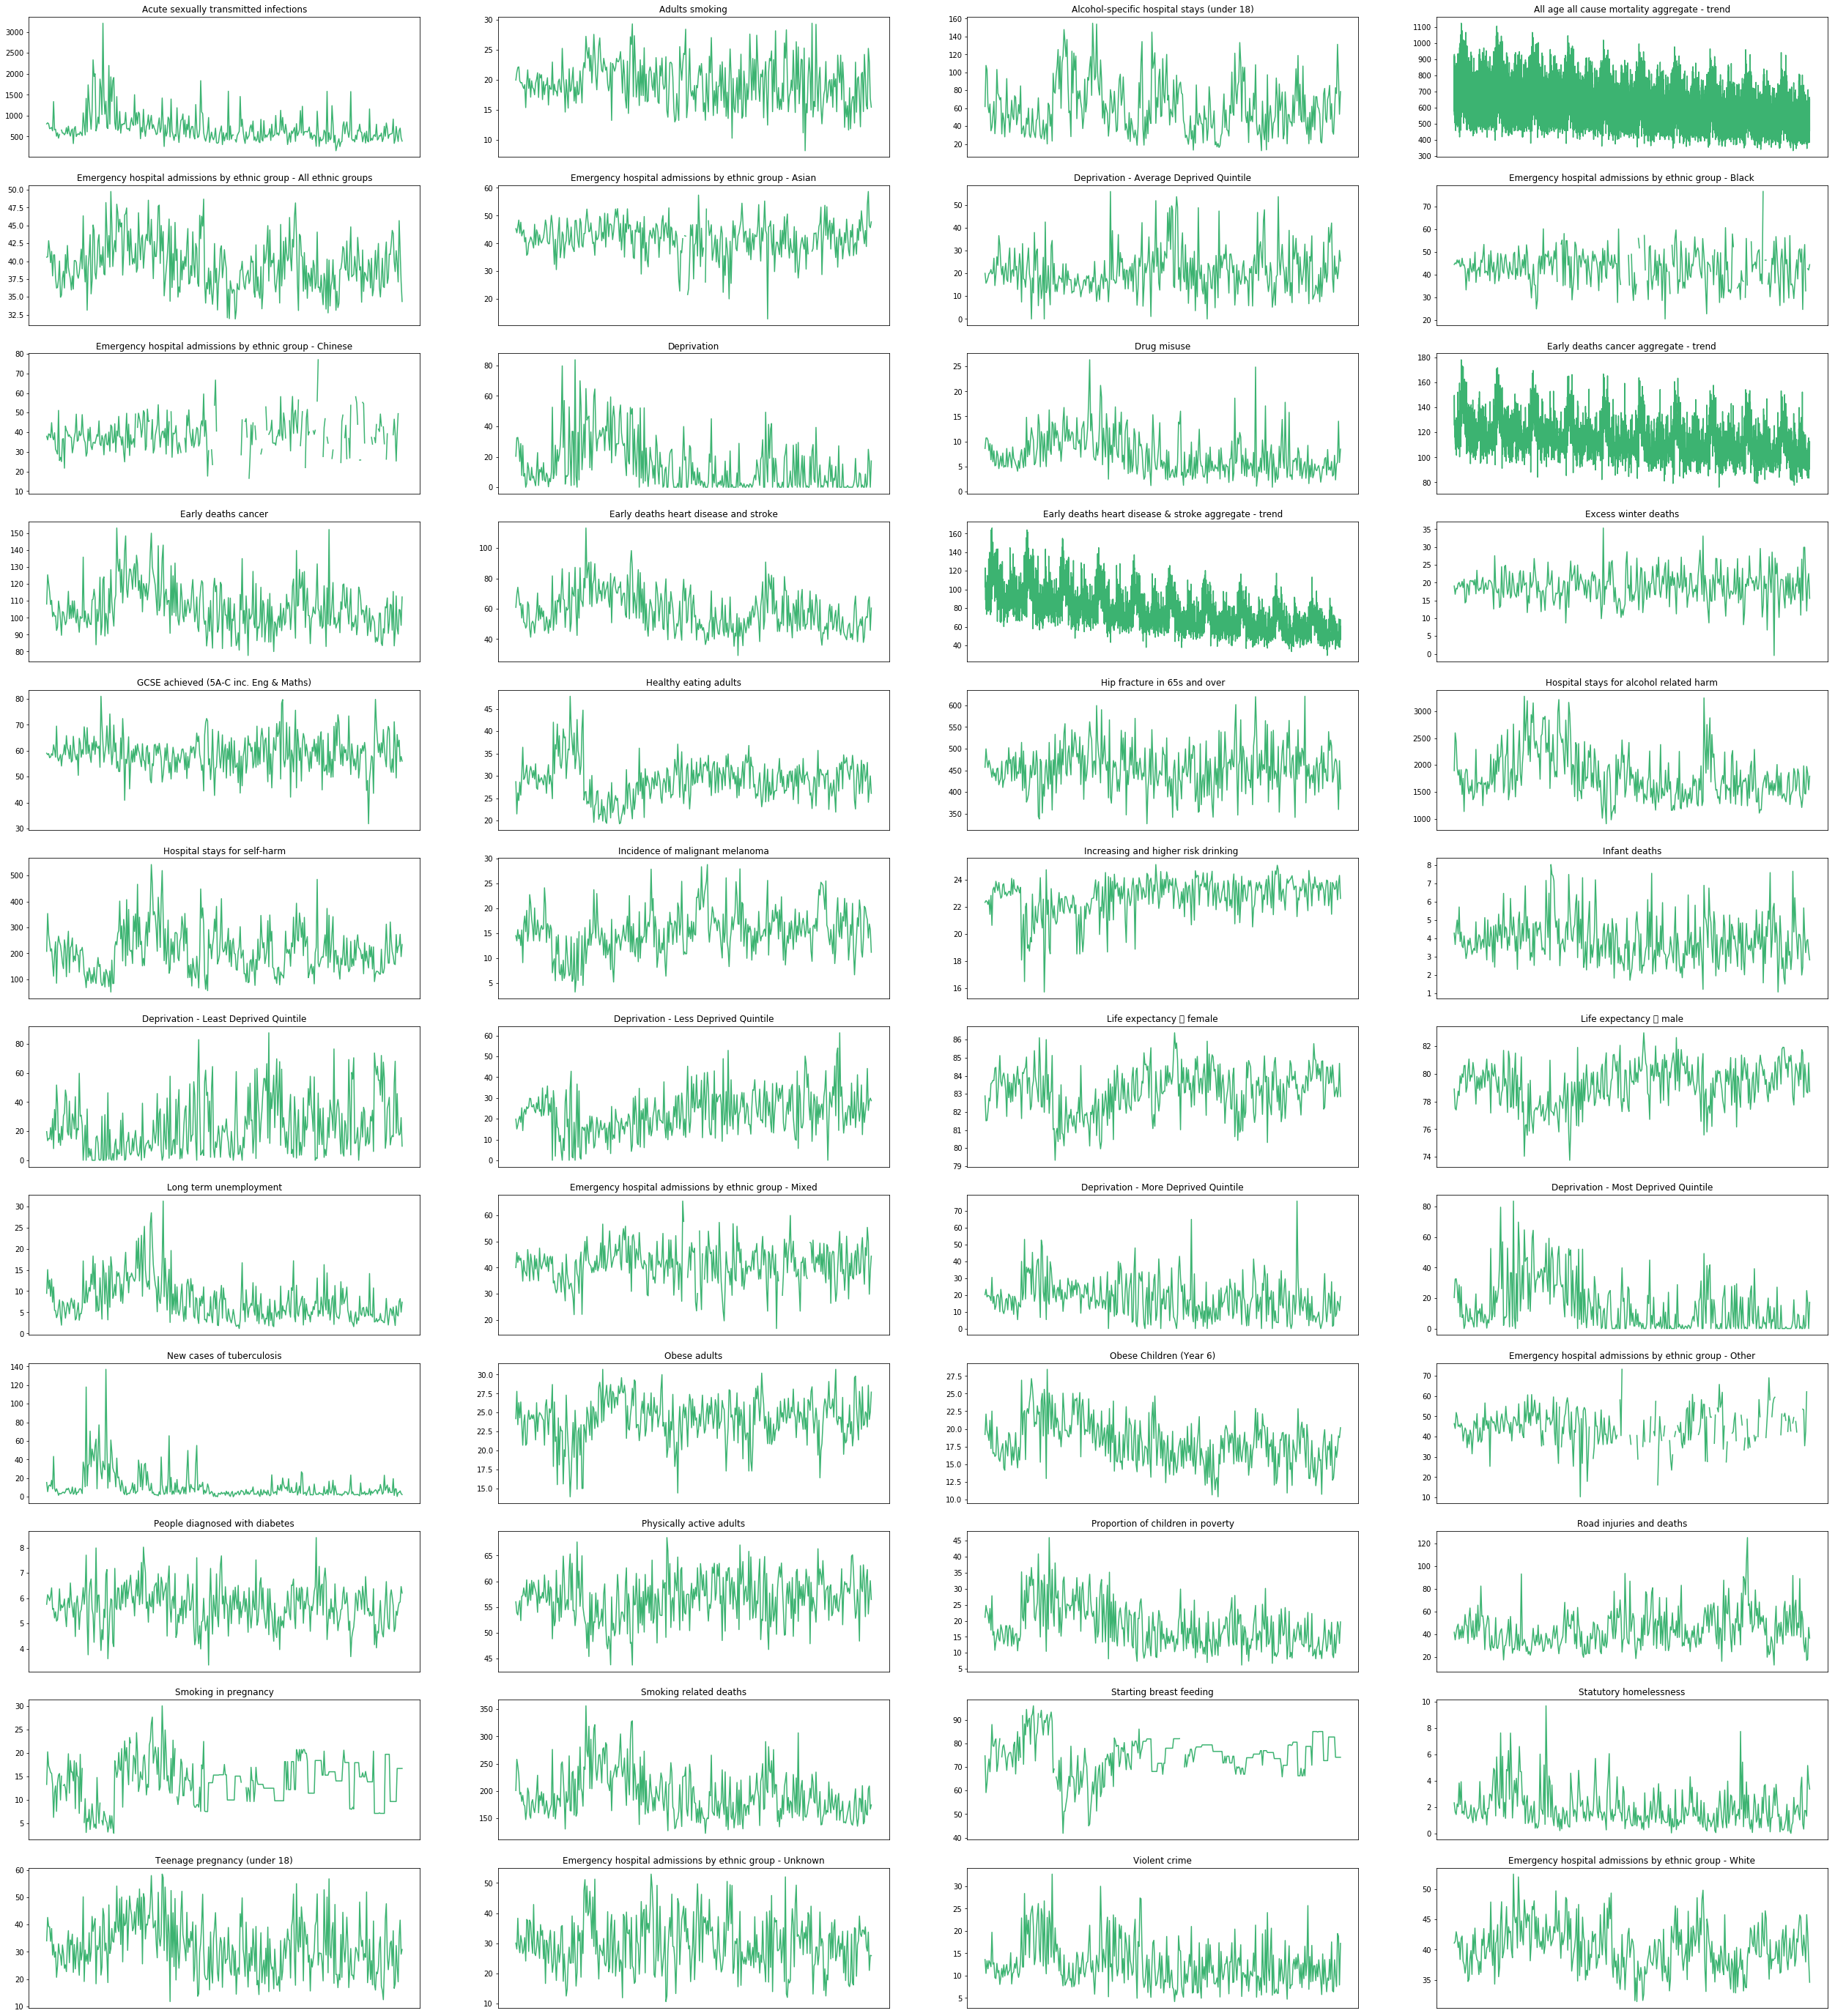

In [9]:
cols = ['File','Description', 'nb_of_columns', 'nb_of_rows']
datasets_sizes = []

plt.figure(figsize=(44, 50))
   
for i, file in enumerate(files):
    df = pd.read_csv(PATH+file, skiprows=19)
    plt.subplot(12, 4, i + 1)
    y=df['Indicator value']
    plt.plot(y, c="mediumseagreen") 
    plt.ylabel('')
    plt.xticks([])
    plt.title(file_description[file])
    datasets_sizes.append([file, file_description[file], df.shape[1], df.shape[0]])

  

In [10]:
data_size = pd.DataFrame(datasets_sizes, columns=cols)
data_size 

,File,Description,nb_of_columns,nb_of_rows
0,AcutesexuallytransmittedinfectionsCSV.csv,Acute sexually transmitted infections,13,361
1,AdultssmokingCSV.csv,Adults smoking,13,361
2,Alcoholspecifichospitalstaysunder18CSV.csv,Alcohol-specific hospital stays (under 18),13,361
3,AllageallcausemortalityaggregatetrendCSV.csv,All age all cause mortality aggregate - trend,13,7220
4,AllethnicgroupsCSV.csv,Emergency hospital admissions by ethnic group ...,13,361
5,AsianCSV.csv,Emergency hospital admissions by ethnic group ...,13,361
6,AveragedeprivedquintileCSV.csv,Deprivation - Average Deprived Quintile,13,361
7,BlackCSV.csv,Emergency hospital admissions by ethnic group ...,13,361
8,ChineseCSV.csv,Emergency hospital admissions by ethnic group ...,13,361
9,DeprivationCSV.csv,Deprivation,13,361


I will investigate the files which differs in size more closely.



In [11]:
#creating the table with fi9les which differ in size
different_size=data_size[data_size['nb_of_rows']!=361]
different_size

,File,Description,nb_of_columns,nb_of_rows
3,AllageallcausemortalityaggregatetrendCSV.csv,All age all cause mortality aggregate - trend,13,7220
11,EarlydeathscanceraggregatetrendCSV.csv,Early deaths cancer aggregate - trend,13,3610
14,EarlydeathsheartdiseasestrokeaggregatetrendCSV...,Early deaths heart disease & stroke aggregate ...,13,3610


In [12]:
Allageallcausemortalityaggregatetrend = pd.read_csv(PATH+'AllageallcausemortalityaggregatetrendCSV.csv', skiprows=19)
Earlydeathscanceraggregatetrend = pd.read_csv(PATH+'EarlydeathscanceraggregatetrendCSV.csv', skiprows=19)
Earlydeathsheartdiseasestrokeaggregatetrend = pd.read_csv(PATH+'EarlydeathsheartdiseasestrokeaggregatetrendCSV.csv', skiprows=19)

In [13]:
# here I print out the frequencies of all the categorical variables in order to investigate why those files differ in size
def cat_frequecies(data):
    """
    This function calculates and prints out the frequencies for all the cathegorical variables in a data frame
    
    data: Pandas dataframe
    """
    categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
    for col in categorical_columns:
        print (f'\nFrequency of Categories for varible {col}')
        print (data[col].value_counts())

In [14]:
cat_frequecies(Allageallcausemortalityaggregatetrend)


Frequency of Categories for varible ONS Code (old)
00AQ    20
24UE    20
00CW    20
34UF    20
42UD    20
18UB    20
17UG    20
00EF    20
41UH    20
18UD    20
00EX    20
00BK    20
00DB    20
00BC    20
42      20
00BA    20
34UC    20
00AX    20
22UH    20
30UE    20
36UE    20
00LC    20
00HE    20
36UF    20
22      20
24UH    20
30UQ    20
29      20
37UB    20
00MD    20
        ..
00AW    20
00KF    20
00MC    20
37UE    20
00HN    20
00BM    20
00CG    20
00AN    20
41UK    20
00CQ    20
34UE    20
00BF    20
00FF    20
36UC    20
47      20
30UM    20
18UL    20
32UC    20
00CY    20
00CA    20
00ET    20
33UH    20
11UC    20
38UF    20
00AR    20
00JA    20
37UF    20
19UJ    20
45UB    20
00EQ    20
Name: ONS Code (old), Length: 361, dtype: int64

Frequency of Categories for varible ONS Code (new)
E07000120    20
E07000089    20
E06000040    20
E08000033    20
E07000049    20
E09000013    20
E07000155    20
E07000095    20
E08000019    20
E07000200    20
E06000047    20
E

In [15]:
cat_frequecies(Earlydeathscanceraggregatetrend)


Frequency of Categories for varible ONS Code (old)
00FD    10
34UG    10
00JA    10
43UJ    10
00BW    10
30UK    10
19UJ    10
00CL    10
00HB    10
00ET    10
38UC    10
00CQ    10
22UD    10
00AN    10
30UP    10
43UF    10
00EE    10
26UC    10
42UF    10
00EH    10
31UE    10
22UN    10
18      10
37      10
38UF    10
22UB    10
47      10
30UM    10
18UL    10
24UC    10
        ..
18UC    10
00BA    10
00CK    10
00EC    10
00FC    10
00AX    10
00KG    10
18UB    10
44UD    10
37UE    10
00HE    10
00KC    10
00HA    10
45UC    10
29UP    10
30UJ    10
33UF    10
22      10
34UH    10
00FF    10
21UG    10
24UE    10
00LC    10
00CW    10
00BE    10
34UF    10
00BS    10
23UE    10
00HP    10
00EQ    10
Name: ONS Code (old), Length: 361, dtype: int64

Frequency of Categories for varible ONS Code (new)
E07000035    10
E07000174    10
E07000175    10
E07000239    10
E09000003    10
E06000020    10
E07000122    10
E07000123    10
E07000198    10
E07000216    10
E07000075    10
E

In [16]:
cat_frequecies(Earlydeathsheartdiseasestrokeaggregatetrend)


Frequency of Categories for varible ONS Code (old)
00FD    10
34UG    10
00JA    10
43UJ    10
00BW    10
30UK    10
19UJ    10
00CL    10
00HB    10
00ET    10
38UC    10
00CQ    10
22UD    10
00AN    10
30UP    10
43UF    10
00EE    10
26UC    10
42UF    10
00EH    10
31UE    10
22UN    10
18      10
37      10
38UF    10
22UB    10
47      10
30UM    10
18UL    10
24UC    10
        ..
18UC    10
00BA    10
00CK    10
00EC    10
00FC    10
00AX    10
00KG    10
18UB    10
44UD    10
37UE    10
00HE    10
00KC    10
00HA    10
45UC    10
29UP    10
30UJ    10
33UF    10
22      10
34UH    10
00FF    10
21UG    10
24UE    10
00LC    10
00CW    10
00BE    10
34UF    10
00BS    10
23UE    10
00HP    10
00EQ    10
Name: ONS Code (old), Length: 361, dtype: int64

Frequency of Categories for varible ONS Code (new)
E07000035    10
E07000174    10
E07000175    10
E07000239    10
E09000003    10
E06000020    10
E07000122    10
E07000123    10
E07000198    10
E07000216    10
E07000075    10
E

### Colnclusions after data exploration

1. Some datasets contain missing values for indicator variable
2. Some datasets contain different frequencies of measurement and as a result differ in size

**Earlydeathscanceraggregatetrend** contains data representing a distribution of the variable over 20 years with measurement every 2 years 

**Earlydeathsheartdiseasestrokeaggregatetrend** contains data representing a distribution of the variable over 20 years with measurement every 2 years 

**Allageallcausemortalityaggregatetrend** contains a distribution of the variable over 20 years with measurment every 2 years for men and woman 

### Further steps
1. Allageallcausemortalityaggregatetrend has been divided according to gender
2. For all the datasets which measured the change of the variable over time, the following new features have been calculated:
    
    - the trend value
    - the mean of all measurements


## Feature engeneering & preparation of data for training

In this section:
- all the additional features are calculated using data aggregation
- all the datasets are joined into one data frame
- missing values are replaced with median value for all variables


In [17]:
#Allageallcausemortalityaggregatetrend divided according to gender
all_cause_mortality_F = Allageallcausemortalityaggregatetrend[Allageallcausemortalityaggregatetrend['Gender'] == 'F']
all_cause_mortality_M = Allageallcausemortalityaggregatetrend[Allageallcausemortalityaggregatetrend['Gender'] == 'M']
# checking sizes of the files after split
len(all_cause_mortality_F), len(all_cause_mortality_M)

(3610, 3610)

In [18]:
# renaming of the indicator variables
Earlydeathscanceraggregatetrend.rename(columns={'Indicator value':'Cancer_death'}, inplace=True)
Earlydeathsheartdiseasestrokeaggregatetrend.rename(columns={'Indicator value':'Heart_death'}, inplace=True)
all_cause_mortality_F.rename(columns={'Indicator value':'all_cause_mortality_F'}, inplace=True)
all_cause_mortality_M.rename(columns={'Indicator value':'all_cause_mortality_M'}, inplace=True)


C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [19]:
def aggregate(df, fldname, agg_func):
    """
    This function:
    - sorts the data by time (necessary if we want to calculate change rate later)
    - aggregates the data
    
    variables
    df: Pandas dataframe
    fldname: name of the column to group by
    agg_funct: a dictionary maping the columns and agregation functions
    
    
    """
    df['start_date']=df['Period'].str[:4].astype(int)
    df.sort_values([fldname,'start_date'], inplace=True)
    
    agg_df=df.groupby(fldname).agg(agg_func)
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    return agg_df

In [20]:
#helper functions used for aggregating values
def trend(arr, abs_values=False):
    """
    function calculates the trend
    """
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]


In [21]:
#'min', 'max', mean_difference, change_rate, 
agg_func={'Cancer_death': ['mean', trend]}
cancer_death_agg= aggregate(Earlydeathscanceraggregatetrend, 'ONS Code (new)', agg_func)

agg_func={'Heart_death': ['mean',  trend]}
heart_disease_agg= aggregate(Earlydeathsheartdiseasestrokeaggregatetrend, 'ONS Code (new)', agg_func)

agg_func={'all_cause_mortality_M': ['mean',  trend]}
all_cause_mortality_M_agg=aggregate(all_cause_mortality_M, 'ONS Code (new)', agg_func)

agg_func={'all_cause_mortality_F': ['mean',  trend]}
all_cause_mortality_F_agg=aggregate(all_cause_mortality_F, 'ONS Code (new)', agg_func)

C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Agata\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [22]:
# merging all the aggregated values
additional_fields = cancer_death_agg.merge(heart_disease_agg, on = 'ONS Code (new)', how='left').merge(all_cause_mortality_M_agg, on = 'ONS Code (new)', how='left').merge(all_cause_mortality_F_agg, on = 'ONS Code (new)', how='left')

In [23]:
#number of additional variable that we created
additional_fields.shape

(361, 9)

### Joining the datasets

In [24]:
#create the list with names of all the files with one row per region
indicator_files=[f for f in files if f not in list(different_size['File'])]
len(indicator_files)

45

In [25]:
#reading the first file
file = PATH+indicator_files[0]
df = pd.read_csv(file, skiprows=19)
df = df.rename(columns = lambda x: x.strip().replace(' ', '_').replace('(', '').replace(')', '').replace('%', '').upper() )
df = df[['ONS_CODE_NEW', 'AREA_NAME', 'INDICATOR_VALUE']]
name=indicator_files[0][:-7]
df.rename(columns={'INDICATOR_VALUE':name}, inplace=True)
df.head(5)


,ONS_CODE_NEW,AREA_NAME,Acutesexuallytransmittedinfections
0,E92000001,England,803.697520
1,E12000001,North East,828.326159
2,E12000002,North West,804.667146
3,E12000003,Yorkshire and the Humber,688.531398
4,E12000004,East Midlands,700.481857


In [26]:
#joining all the other files
for f in indicator_files[1:]:
    data = pd.read_csv(PATH+f, skiprows=19)
    data = data.rename(columns = lambda x: x.strip().replace(' ', '_').replace('(', '').replace(')', '').replace('%', '').upper() )
    name=f[:-7]
    data.rename(columns={'INDICATOR_VALUE':name}, inplace=True)
    df = pd.merge(df, data[['ONS_CODE_NEW', name]], on='ONS_CODE_NEW', how='left')
    
df.shape  

(361, 47)

In [27]:
# # adding additional variables calculated earlier
additional_fields.rename(columns={'ONS Code (new)':'ONS_CODE_NEW'}, inplace=True)
df=df.merge(additional_fields, on = 'ONS_CODE_NEW', how='left')


In [28]:
f'Training data has {df.shape[0]} rows and {df.shape[1]} columns'

'Training data has 361 rows and 55 columns'

### Missing values

In [29]:
#the proportion of teh missing values per each variable
df.isnull().sum().sort_index()/len(df)

AREA_NAME                              0.000000
Acutesexuallytransmittedinfections     0.005540
Adultssmoking                          0.000000
Alcoholspecifichospitalstaysunder18    0.000000
Allethnicgroups                        0.000000
Asian                                  0.016620
Averagedeprivedquintile                0.000000
Black                                  0.074792
Cancer_death_mean                      0.000000
Cancer_death_trend                     0.000000
Chinese                                0.216066
Deprivation                            0.000000
Drugmisuse                             0.000000
Earlydeathscancer                      0.000000
Earlydeathsheartdiseaseandstroke       0.000000
Excesswinterdeaths                     0.000000
GCSEachieved5ACincEngMaths             0.000000
Healthyeatingadults                    0.000000
Heart_death_mean                       0.000000
Heart_death_trend                      0.000000
Hipfracturein65sandover                0

In [30]:
def missing_values(df):
    """ 
    function replaces missing values with median values

    df: Pandas dataframe
    """
    for label, col in df.items(): 
        if is_numeric_dtype(col) :
            if pd.isnull(col).sum() :
                df[label] = col.fillna(col.median())
                

In [31]:
missing_values(df)

In [32]:
#checking if there are any missing values left
df.isnull().values.any()

False

In [33]:
# extracting only numeric columns for analysis of correlations
features = [c for c in df.columns if c not in ['ONS_CODE_NEW', 'AREA_NAME']]
data=df[features]

### Correlations

In [34]:
# Create correlation matrix
corr_matrix = data.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
s = upper.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

In [35]:
#most correlated pairs of indexes
df_corr=so.reset_index()

df_corr['feature_1']=df_corr['level_0'].map(indicator_desc).fillna(df_corr['level_0'])
df_corr['feature_2']=df_corr['level_1'].map(indicator_desc).fillna(df_corr['level_1'])
#df_corr['feature_1','feature_2','0'][:15]
df_corr[:15]

,level_0,level_1,0,feature_1,feature_2
0,Mostdeprivedquintile,Deprivation,1.000000,Deprivation - Most Deprived Quintile,Deprivation
1,White,Allethnicgroups,0.963324,Emergency hospital admissions by ethnic group ...,Emergency hospital admissions by ethnic group ...
2,all_cause_mortality_M_mean,Lifeexpectancymale,0.959522,all_cause_mortality_M_mean,Life expectancy  male
3,all_cause_mortality_M_mean,Heart_death_mean,0.959465,all_cause_mortality_M_mean,Heart_death_mean
4,all_cause_mortality_F_mean,all_cause_mortality_M_mean,0.957220,all_cause_mortality_F_mean,all_cause_mortality_M_mean
5,Heart_death_mean,Earlydeathsheartdiseaseandstroke,0.953782,Heart_death_mean,Early deaths heart disease and stroke
6,all_cause_mortality_F_mean,Lifeexpectancyfemale,0.945681,all_cause_mortality_F_mean,Life expectancy  female
7,Cancer_death_mean,Smokingrelateddeaths,0.940456,Cancer_death_mean,Smoking related deaths
8,all_cause_mortality_M_mean,Cancer_death_mean,0.933224,all_cause_mortality_M_mean,Cancer_death_mean
9,Cancer_death_mean,Earlydeathscancer,0.931129,Cancer_death_mean,Early deaths cancer


In [36]:
from scipy.cluster import hierarchy as hc
import scipy

In [37]:
# creating a list with descriptions of all the columns in the data
column_description=[indicator_desc[i] if i in indicator_desc.keys() else i for i in list(data.columns) ]

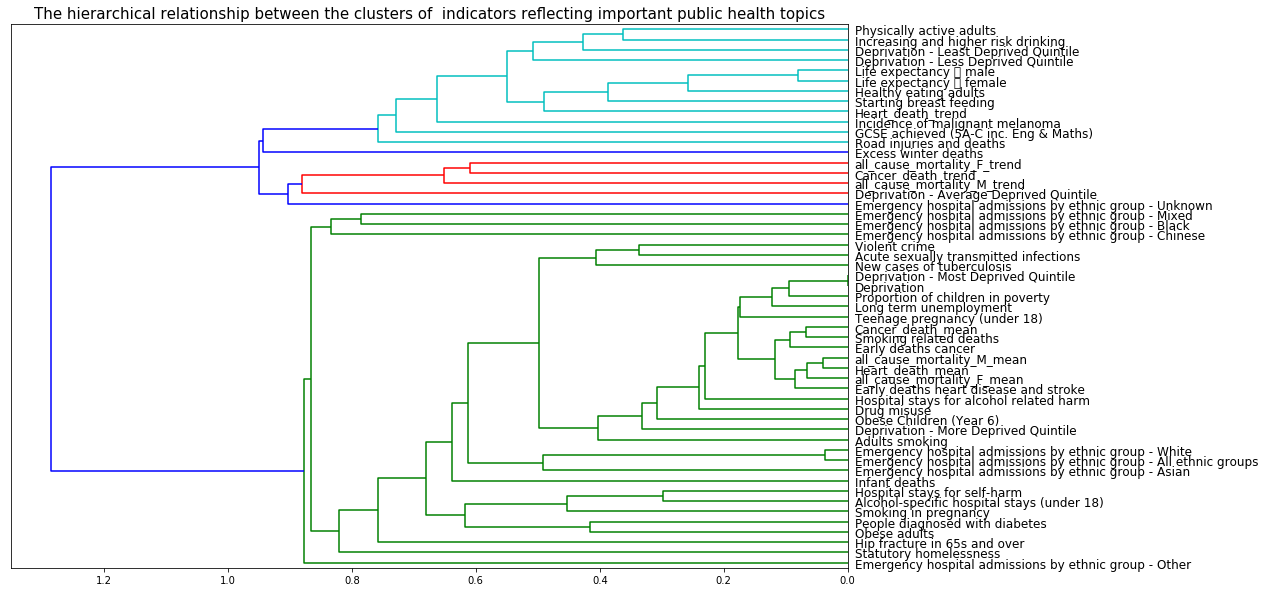

In [38]:
#hierarhical clustering
corr = np.round(scipy.stats.spearmanr(data).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(15,10))
plt.title('The hierarchical relationship between the clusters of  indicators reﬂecting important public health topics', fontsize=15)
dendrogram = hc.dendrogram(z, labels=column_description, orientation='left', leaf_font_size=12)
plt.show()

### Conclusions from analysis of correlations
1. Mostdeprivedquintile and Deprivation are perfectly correlated so only one of those variables will be used for further analysis
2. There are variables which are highly correlated because the information convayed by one is included in the other, for example 'Emergency hospital admissions by ethnic group - White' and 'Emergency hospital admissions by ethnic group - All ethnic groups' 

3. Two primary clusters have been identified: 
    - Cluster 1 - grouping all variables related to diseases, health issues and mortality, e.g. hospital admissions, obesity and smoking
    - Cluster 2 - grouping all variables describing healthy lifestyle, e.g. physically active adults, healthy eating adults and life expectancy


### PCA model
As part of data exploration PCA model has been applied in order to understand the data better and discover any latent characteristics of the dataset



In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [40]:
#standardising the data
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

In [41]:
#2 principal components
pca = PCA(n_components=2)

In [42]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [43]:
x_pca = pca.transform(scaled_data)

In [44]:
x_pca.shape

(361, 2)

In [45]:
# the amount of explained variance by calculated principal components
print(pca.explained_variance_)

[21.37175293  5.4268781 ]


In [46]:
# the variables with biggest positive contributions to first pc
first_comp = [(f, i) for f,i in zip(pca.components_[0], column_description)]
first_sorted=sorted(first_comp, key=lambda o: o[0], reverse=True)
first_sorted[:15]

[(0.20788016051914662, 'all_cause_mortality_M_mean'),
 (0.20642818897663515, 'Heart_death_mean'),
 (0.20137052566362795, 'Smoking related deaths'),
 (0.19942185012923513, 'Cancer_death_mean'),
 (0.19940980324751567, 'Early deaths heart disease and stroke'),
 (0.19780219429906976, 'Deprivation - Most Deprived Quintile'),
 (0.19780219429906973, 'Deprivation'),
 (0.19700202353629112, 'all_cause_mortality_F_mean'),
 (0.19323189383327904, 'Early deaths cancer'),
 (0.19168407022801792, 'Proportion of children in poverty'),
 (0.18910384977698605, 'Teenage pregnancy (under 18)'),
 (0.18570990078593452, 'Long term unemployment'),
 (0.18368182764038887, 'Hospital stays for alcohol related harm'),
 (0.1724384978316228, 'Drug misuse'),
 (0.16416555817155515, 'Obese Children (Year 6)')]

In [47]:
# the variables with biggest negative contributions to first pc
first_sorted[-15:]

[(-0.025763762340043544, 'Excess winter deaths'),
 (-0.03035805827418863, 'Deprivation - Average Deprived Quintile'),
 (-0.06835870098566511, 'all_cause_mortality_M_trend'),
 (-0.07598799717921804, 'Road injuries and deaths'),
 (-0.08855286136992323, 'GCSE achieved (5A-C inc. Eng & Maths)'),
 (-0.10070953823407203, 'Incidence of malignant melanoma'),
 (-0.10251919571652889, 'Starting breast feeding'),
 (-0.13790748224298024, 'Healthy eating adults'),
 (-0.1411136796563602, 'Deprivation - Less Deprived Quintile'),
 (-0.14346782088859789, 'Increasing and higher risk drinking '),
 (-0.14681468343283, 'Physically active adults'),
 (-0.15141772742725226, 'Heart_death_trend'),
 (-0.15832242006139247, 'Deprivation - Least Deprived Quintile'),
 (-0.19130094617506727, 'Life expectancy \x96 female'),
 (-0.20436909655953028, 'Life expectancy \x96 male')]

In [48]:
# the variables with biggest positive contributions to second pc
second_comp = [(f, i) for f,i in zip(pca.components_[1], column_description)]
second_sorted=sorted(second_comp, key=lambda o: o[0], reverse=True)
second_sorted[:15]

[(0.3264087445285708, 'New cases of tuberculosis'),
 (0.2928737615932057, 'Starting breast feeding'),
 (0.27347831302367603, 'Healthy eating adults'),
 (0.2659811112739685, 'Acute sexually transmitted infections'),
 (0.21408846776059728, 'Statutory homelessness'),
 (0.21075638410304656, 'Violent crime'),
 (0.14207633186804502, 'Proportion of children in poverty'),
 (0.11940855080802927, 'Obese Children (Year 6)'),
 (0.11552128035167966, 'Life expectancy \x96 female'),
 (0.11343686491564323, 'Deprivation - More Deprived Quintile'),
 (0.10132147503997917, 'GCSE achieved (5A-C inc. Eng & Maths)'),
 (0.09842505741483877,
  'Emergency hospital admissions by ethnic group - White'),
 (0.07863602473725159, 'Physically active adults'),
 (0.06736369757117278,
  'Emergency hospital admissions by ethnic group - All ethnic groups'),
 (0.0659916314242011, 'Deprivation - Most Deprived Quintile')]

In [49]:
# the variables with biggest negative contributions to second pc
second_sorted[-15:]

[(-0.07976228303178096, 'Early deaths cancer'),
 (-0.07997667902999117, 'all_cause_mortality_F_mean'),
 (-0.08773025824794514, 'Cancer_death_trend'),
 (-0.10299045821130164, 'Hip fracture in 65s and over'),
 (-0.10714854142729119, 'all_cause_mortality_M_trend'),
 (-0.10726145792946959, 'People diagnosed with diabetes'),
 (-0.11695984246289329,
  'Emergency hospital admissions by ethnic group - Mixed'),
 (-0.12321398247456737, 'all_cause_mortality_F_trend'),
 (-0.13347646755811096, 'Deprivation - Less Deprived Quintile'),
 (-0.19230846350011213, 'Incidence of malignant melanoma'),
 (-0.19422209807723717, 'Increasing and higher risk drinking '),
 (-0.2029795440200869, 'Alcohol-specific hospital stays (under 18)'),
 (-0.22713092451971764, 'Hospital stays for self-harm'),
 (-0.24467182239584284, 'Obese adults'),
 (-0.3149304406399324, 'Smoking in pregnancy')]

In [50]:
#visualising the components
X = pca.components_[0]
Y = pca.components_[1]
first_df=pd.DataFrame(data=X, index=column_description, columns=['first component']) 
first_df.sort_values(by=['first component'], axis=0, ascending=False, inplace=True)

In [51]:
second_df=pd.DataFrame(data=Y, index=column_description, columns=['second component']) 
second_df.sort_values(by=['second component'], axis=0, ascending=False, inplace=True)

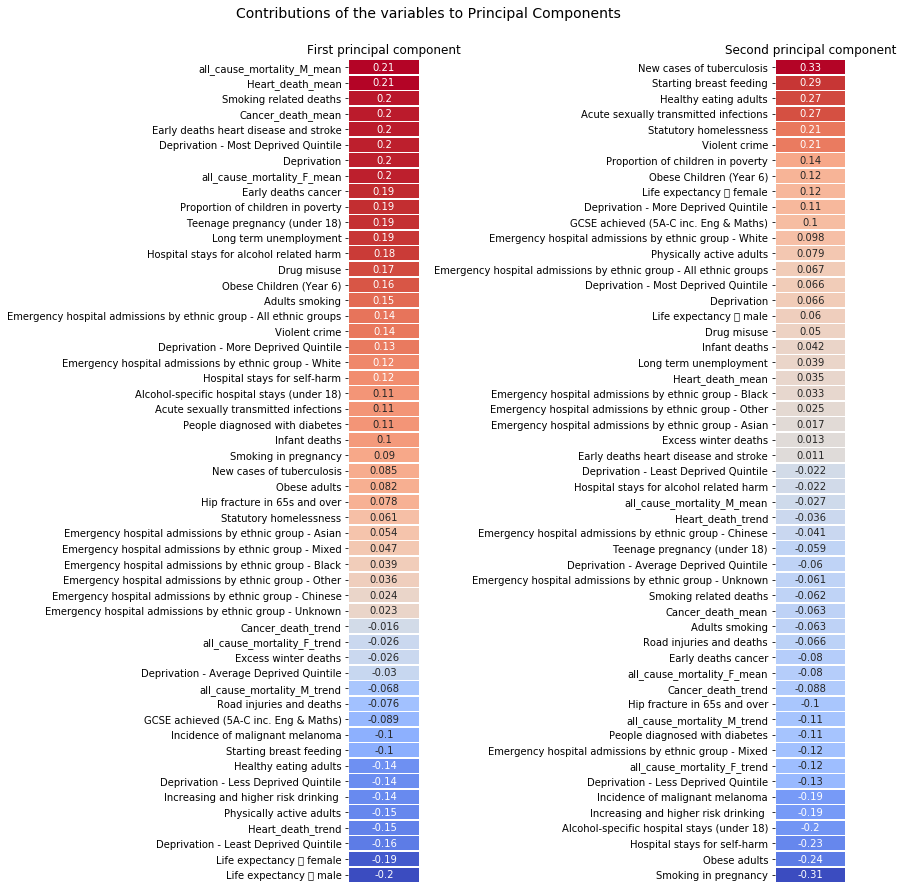

In [52]:
plt.figure(figsize=(12,12))
plt.suptitle('Contributions of the variables to Principal Components', fontsize=14, y=1.03)
plt.subplot(1, 2, 1)
plt.title('First principal component')
sns.heatmap(first_df,cmap='coolwarm',annot=True, linewidth=0.5, cbar=False, xticklabels=False)

plt.subplot(1, 2, 2)
plt.title('Second principal component')
sns.heatmap(second_df,cmap='coolwarm',annot=True, linewidth=0.5, cbar=False, xticklabels=False)

plt.tight_layout()

# Predictive model
In this section:
- a predictive model is developped using random forest
- the features with the biggest impact on the target variable are identified and examined

In [53]:
#removing the features connected to death to avoid information lekeage
features = [c for c in df.columns if c not in ['ONS_CODE_NEW', 'AREA_NAME', 'Earlydeathsheartdiseaseandstroke', 
 'Mostdeprivedquintile',
 'Allethnicgroups',
 'Asian',
 'Black',
 'Chinese',
 'Lifeexpectancyfemale',
 'Lifeexpectancymale',
 'Mixed',
 'Other',
 'Smokingrelateddeaths',
 'Unknown',
 'White',
 'Heart_death_mean',
 'Heart_death_trend',
 'all_cause_mortality_M_mean',
 'all_cause_mortality_M_trend',
 'all_cause_mortality_F_mean',
 'all_cause_mortality_F_trend',
 'Cancer_death_mean'
]]
target = df['Earlydeathsheartdiseaseandstroke']

In [54]:
train = df[features]

In [55]:
# checking if data is in the right format for training
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 33 columns):
Acutesexuallytransmittedinfections     361 non-null float64
Adultssmoking                          361 non-null float64
Alcoholspecifichospitalstaysunder18    361 non-null float64
Averagedeprivedquintile                361 non-null float64
Deprivation                            361 non-null float64
Drugmisuse                             361 non-null float64
Earlydeathscancer                      361 non-null float64
Excesswinterdeaths                     361 non-null float64
GCSEachieved5ACincEngMaths             361 non-null float64
Healthyeatingadults                    361 non-null float64
Hipfracturein65sandover                361 non-null float64
Hospitalstaysforalcoholrelatedharm     361 non-null float64
Hospitalstaysforselfharm               361 non-null float64
Incidenceofmalignantmelanoma           361 non-null float64
Increasingandhigherriskdrinking        361 non-null flo

### Train test split

In [56]:
# create training and validation sets using 20% of random records for validation set
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(288, 33) (288,)
(73, 33) (73,)


In [57]:
def rmse(pred,act): 
    """
    function returns root mean squarre error 
    
    variables
    pred: predictions
    act: actual target values
    """
    return math.sqrt(((pred-act)**2).mean())

def print_score(m):
    """
    this functions prints out rmse for train and validation set R^2 for train and validation set and optionally OOB score
    """
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Random Forest

In [58]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[2.2103325062432173, 7.1723547868757285, 0.971235717753326, 0.7360167436969862, 0.7968947570125811]


RMSE for validation set is much higher than for test set, which can suggest that the model is overfit.
In order to reduce overfitting, the parameters min_samples_leaf and max_features have been added to the model. It reduced RMSE for the validation set i.e. created a model which generalises better.

In [67]:
m = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, max_features='sqrt', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[3.893762157020761, 7.037642710533793, 0.9107358322720457, 0.7458399527097624, 0.8071598074854084]


### Interpretation of results

### Feature importance

In [61]:
fi=pd.DataFrame({'cols':train.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [62]:
#adding descripion of column names
fi['description']=fi['cols'].map(indicator_desc)

In [63]:
fi[:10]

,cols,imp,description
4,Deprivation,0.149611,Deprivation
6,Earlydeathscancer,0.124249,Early deaths cancer
18,Longtermunemployment,0.107849,Long term unemployment
25,Proportionofchildreninpoverty,0.085452,Proportion of children in poverty
30,Teenagepregnancyunder18,0.083315,Teenage pregnancy (under 18)
11,Hospitalstaysforalcoholrelatedharm,0.074469,Hospital stays for alcohol related harm
5,Drugmisuse,0.048215,Drug misuse
9,Healthyeatingadults,0.043894,Healthy eating adults
19,Moredeprivedquintile,0.029557,Deprivation - More Deprived Quintile
1,Adultssmoking,0.028283,Adults smoking


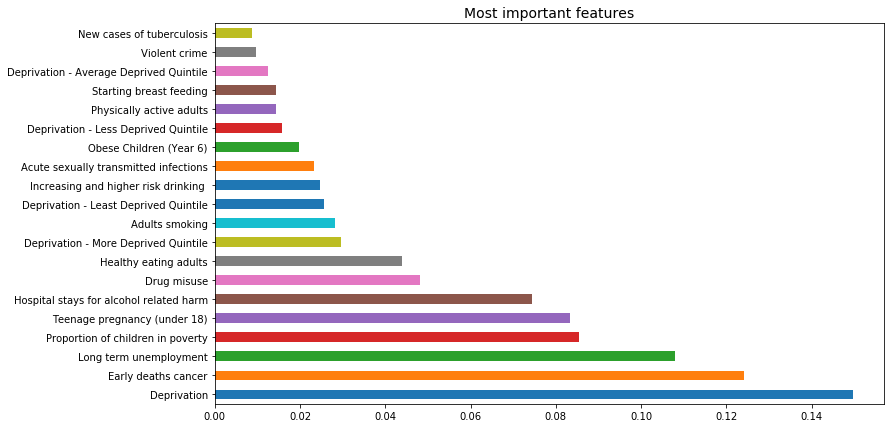

In [64]:
#plot of 20 most important features with the measure of their importance
fi[:20].plot('description', 'imp', 'barh', figsize=(12,7), legend=False)
plt.ylabel('')
plt.title('Most important features', fontsize=14);

### Visualising the relationship between the most important variables

In [65]:
def plot_features(df, arr, y):
    '''
    this function generates the plots
    
    df: dataframe with all the data
    arr: list containing names of variables
    y: target variable
    '''
    plt.figure(figsize=(20, 15))
    plt.suptitle('Relationships between early mortality rate from all circulatory diseases and the most important features in the model', fontsize=16, y=1.05)
    for i, f in enumerate(arr):
        x=df[f]
        plt.subplot(3, 2, i + 1)
        plt.scatter(x,y)
        if f=='Deprivation':
            plt.xlabel('Proportion of people living in the most deprived national quintile in an area')
        else:
            plt.xlabel(indicator_desc[f])
        plt.ylabel('Early mortality rate from all circulatory diseases')
        plt.ylabel('Early mortality rate from all circulatory diseases')
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x,p(x),"r")
        plt.tight_layout()
        #subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)


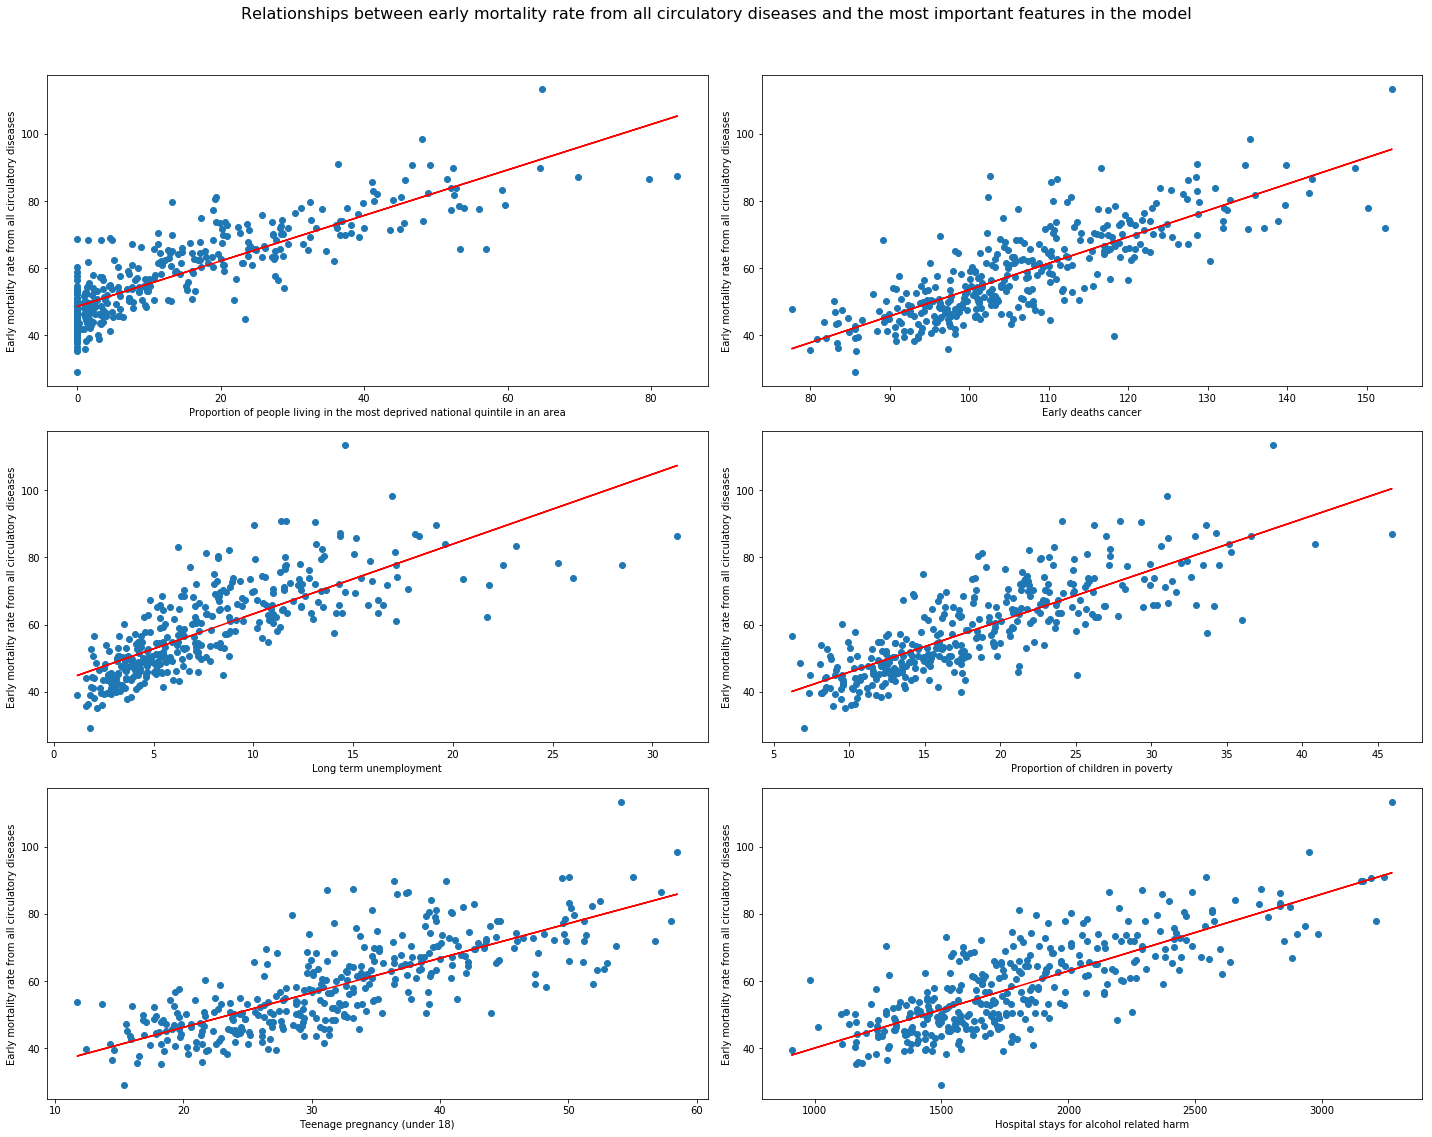

In [66]:
plot_features(data, fi[:6]['cols'], target)
